In [27]:
import cv2
import matplotlib.pyplot as plt
from torch import nn
import torch
from safetensors.torch import load_model

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Data Processing

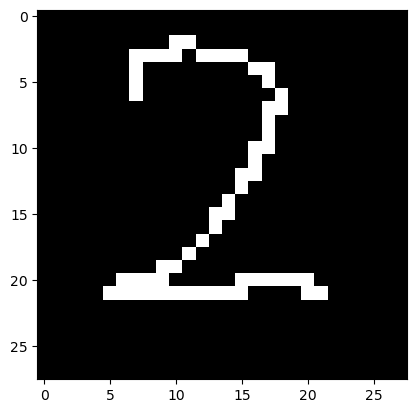

In [29]:
test_pic = cv2.imread("data/digits/dig_2.png")
test_pic = cv2.cvtColor(test_pic, cv2.COLOR_BGR2GRAY)
_, test_pic = cv2.threshold(test_pic, 127, 255, cv2.THRESH_BINARY_INV)
plt.imshow(test_pic, cmap="gray")

In [30]:
test_pic = torch.from_numpy(test_pic).unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float32).to(device)
test_pic.shape

torch.Size([1, 1, 28, 28])

### Load Model

In [31]:
class TinyVGG(nn.Module):

    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(1, 10, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*7*7, 10+1) # 7 * 7 because maxpool has been done twice which divides the shape of image by 2 twice
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

model = TinyVGG().to(device)
load_model(model, "tinyvgg.safetensors")

(set(), [])

### Test Model

In [32]:
model.eval()
with torch.inference_mode():
    results = model(test_pic)
    pred = results.argmax(dim=1)
    conf = torch.softmax(results, dim=1)[0][pred] * 100

print(f"Predicted Digit: {pred.item()} | Confidence: {conf.item():.2f}%")

Predicted Digit: 2 | Confidence: 100.00%
